In [70]:
ALL_CHAR_SET = alphapet = [
                'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي',
                '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩'
            ]
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 64
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='char')

vectorizer.fit(alphapet)
len(alphapet)

38

In [ ]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

encode("ن")

In [78]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader , random_split
import tqdm 

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data_dir,  transform=None):
        self.data_dir = data_dir
        self.files = os.listdir(data_dir)
        self.samples = []
        self.alphapet = [
                'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي',
                '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩'
            ]
    
        self.vectorizer = CountVectorizer(analyzer='char')
        for filename in self.files:
            if filename.endswith('.jpg'):
                base_name = os.path.splitext(filename)[0]
                txt_name = base_name + '.txt'
                if txt_name in self.files:
                    self.samples.append( (filename, txt_name) )# ,CustomDataset.read_text(self.data_dir + txt_name) ))

        self.vectorizer.fit(self.alphapet )
        # if train :
        #     self.vectorizer.fit_transform(np.array([txt_emb for _ , _ ,txt_emb in self.samples]))
        # else:
        #     self.vectorizer.transform(np.array([txt_emb for _ , _ ,txt_emb in self.samples]))

        self.transform = transform

    def __len__(self):

        return len(self.samples)

    def __getitem__(self, idx):
        img_name, txt_name  = self.samples[idx]
        img_path = os.path.join(self.data_dir, img_name)
        txt_path = os.path.join(self.data_dir, txt_name)
        
        image = Image.open(img_path)
        with open(txt_path, 'r') as txt_file:
            text = txt_file.read()
        
        if self.transform:
            image = self.transform(image)
        
        # print(txt_raw + "asdsss"  )
        # print(self.vectorizer.transform([txt_raw]))
        return {'image': image, 'text': text, 'embeddings' : self.vectorizer.transform(CustomDataset.read_text(self.data_dir + txt_name) ).toarray() }
    


    @staticmethod
    def read_text(txt_path):
        with open(txt_path, 'r') as txt_file:
                text = txt_file.read()

        return text


In [80]:
def read_text(txt_path):
        with open(txt_path, 'r') as txt_file:
                text = txt_file.read()

        return text
vectorizer.transform(list(read_text('../data/OCR_Text_Dataset/OCR_Text/10.txt')))

<55x38 sparse matrix of type '<class 'numpy.int64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [73]:
# Set your data directory and other relevant parameters
data_directory = '../data/OCR_Text_Dataset/OCR_Text/'
batch_size = 16


# Define transformation for the images (you can modify this based on your needs)
image_transform = transforms.Compose([
    transforms.Resize((32, 256)),
    transforms.Grayscale() ,
        
    transforms.ToTensor(),
])

# Create the dataset and data loaders
custom_dataset = CustomDataset(data_dir=data_directory, transform=image_transform)

train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size



train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



# data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True )


In [77]:
batch = next(iter(train_dataloader))
batch.keys() , batch["image"].shape

RuntimeError: stack expects each tensor to be equal size, but got [49, 38] at entry 0 and [54, 38] at entry 1

In [32]:
import torch.nn as nn
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [38]:
model = CRNN(opt)
output = model(batch["image"])
output.shape , batch["embeddings"].shape

(torch.Size([16, 65, 38]), torch.Size([16, 1, 38]))

In [35]:
import torch 
import math
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [56]:
loss_fn = CustomCTCLoss()
pred_sizes = torch.full(size=(output.size(0),), fill_value=output.size(0), dtype=torch.int32)
target_sizes = torch.full((batch["image"].size(0),), len(batch["embeddings"][0]), dtype=torch.int32)
loss_fn(output.permute(1,0,2), batch["embeddings"].squeeze(1), pred_sizes, target_sizes)

tensor(-4.4107, grad_fn=<MeanBackward0>)

Text(0.5, 1.0, '1031 شارع المضمار متفرع من كارناتش في ٤٨١ بهلول')

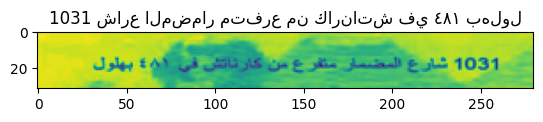

In [12]:
import matplotlib.pyplot as plt

plt.imshow(batch["image"][0].permute(1,2,0).numpy())
plt.title(batch["text"][0])

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
class CRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=2):
        super(CRNN, self).__init__()
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Convolutional layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Recurrent layers
        self.rnn = nn.LSTM(input_size=128, hidden_size=hidden_size,
                           num_layers=num_layers, bidirectional=True, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, images, embeddings):
        # Process images through CNN
        images = self.cnn(images)

        # Reshape the CNN output for RNN
        batch_size, channels, height, width = images.size()
        images = images.permute(0, 3, 1, 2).contiguous().view(batch_size, width, channels * height)

        # Combine image features and embeddings
        combined_features = torch.cat((images, embeddings), dim=2)

        # Process combined features through RNN
        rnn_output, _ = self.rnn(combined_features)

        # Apply fully connected layer
        logits = self.fc(rnn_output)

        return logits
    
model = CRNN(ALL_CHAR_SET_LEN , 28 )
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



device = torch.device('cpu')
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in data_loader:
        images = batch['image']
        text = batch['text']
        embeddings = batch['embeddings']

        optimizer.zero_grad()

        logits = model(images, embeddings)
        logits = logits.permute(1, 0, 2)  # Transpose for CTC loss compatibility
        logit_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.int32)
        target_lengths = torch.full((batch["image"].size(0),), len(batch["embeddings"][0]), dtype=torch.int32)

        loss = criterion(logits, text, logit_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss / len(data_loader)}")



RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 70 but got size 1 for tensor number 1 in the list.

In [26]:

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)


Using cache found in /home/aylore/.cache/torch/hub/pytorch_vision_v0.10.0
/home/aylore/anaconda3/envs/grad/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aylore/anaconda3/envs/grad/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
nh = 64
nclass = ALL_CHAR_SET_LEN 

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output
    
rnn = nn.Sequential(
            BidirectionalLSTM(2432, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

In [34]:
output = resnet(batch["image"])
output.shape

torch.Size([16, 2432])

In [35]:
rnn(output)

ValueError: not enough values to unpack (expected 3, got 2)

In [30]:
# loss = loss_fn(outputs, targets.squeeze(1), input_lengths  ,  target_lengths)
input_lengths = torch.full((batch["image"].size(0),), output.size(0), dtype=torch.int32)
target_lengths = torch.full((batch["image"].size(0),), len(batch["embeddings"][0]), dtype=torch.int32)

loss_fn(output , batch["embeddings"].squeeze(1) , input_lengths  ,target_lengths)

RuntimeError: input_lengths must be of size batch_size

In [13]:
import torch.nn as nn

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        # 1x32x128
        self.conv1 = nn.Conv2d(nc, 64, 3, 1, 1)
        self.relu1 = nn.ReLU(True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # 64x16x64
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.relu2 = nn.ReLU(True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # 128x8x32
        self.conv3_1 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3_1 = nn.ReLU(True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, 1, 1)
        self.relu3_2 = nn.ReLU(True)
        self.pool3 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))

        # 256x4x16
        self.conv4_1 = nn.Conv2d(256, 512, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.relu4_2 = nn.ReLU(True)
        self.pool4 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))

        # 512x2x16
        self.conv5 = nn.Conv2d(512, 512, 2, 1, 0)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU(True)

        # 512x1x16

        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))


    def forward(self, input):
        # conv features
        x = self.pool1(self.relu1(self.conv1(input)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3_2(self.conv3_2(self.relu3_1(self.bn3(self.conv3_1(x))))))
        x = self.pool4(self.relu4_2(self.conv4_2(self.relu4_1(self.bn4(self.conv4_1(x))))))
        conv = self.relu5(self.bn5(self.conv5(x)))
        # print(conv.size())

        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return outputa

In [19]:
crnn = CRNN(256 , 1 , 37,256)
output = crnn(batch["image"][0].unsqueeze(0))
output.shape , batch["embeddings"].shape

(torch.Size([71, 1, 37]), torch.Size([16, 1, 38]))

In [21]:
# loss = loss_fn(outputs, targets.squeeze(1), input_lengths  ,  target_lengths)
input_lengths = torch.full((batch["image"].size(0),), output.size(0), dtype=torch.int32)
target_lengths = torch.full((batch["image"].size(0),), len(batch["embeddings"][0]), dtype=torch.int32)

loss_fn(output , batch["embeddings"].squeeze(1) , input_lengths  ,target_lengths)

RuntimeError: input_lengths must be of size batch_size

In [15]:
def decode_ctc_output(output, charset):
    """
    Decode the CRNN model's output to text.

    Args:
        output (Tensor): The model's output tensor, typically with shape (T, N, C).
        charset (str): A string containing the character set, where each character corresponds to a label.

    Returns:
        str: The decoded text.
    """
    # Convert the output tensor to a numpy array
    output = output.cpu().detach().numpy()

    # Perform character decoding (select the character with the highest probability at each time step)
    decoded_labels = []
    for timestep in output:
        timestep_labels = [charset[label] for label in np.argmax(timestep, axis=1)]
        decoded_labels.append(timestep_labels)

    # Collapse consecutive identical characters and remove blank symbols (if using CTC)
    collapsed_labels = []
    prev_label = None
    for labels in decoded_labels:
        for label in labels:
            if label != prev_label:
                collapsed_labels.append(label)
            prev_label = label

    # Map the character labels to actual Arabic characters
    decoded_text = ''.join(collapsed_labels)

    return decoded_text


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , random_split
from tqdm import tqdm
from Levenshtein import distance 

# Create the dataset and data loaders

# Define transformation for the images (you can modify this based on your needs)
image_transform = transforms.Compose([
    transforms.Resize((32, 280)),
    transforms.Grayscale() ,
        
    transforms.ToTensor(),
])


dataset = CustomDataset(data_dir=data_directory, transform=image_transform)
# data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True )


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size



train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



loss_fn = nn.CTCLoss()
optimizer = optim.Adam(crnn.parameters(), lr=0.001)




def calculate_cer(pred_text, target_text):
    return distance(pred_text, target_text) / max(len(pred_text), len(target_text))

num_epochs = 10  # Adjust the number of epochs

for epoch in range(num_epochs):
    crnn.train()  # Set the model to training mode
    total_loss = 0.0

    # Training loop
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} Training', leave=False):
        inputs, targets = batch["image"]   , batch["embeddings"]
        optimizer.zero_grad()
        
        # Forward pass
        outputs = crnn(inputs)
        outputs = outputs.permute(1, 0, 2)  # Swap batch and sequence dimensions
        input_lengths = torch.full((inputs.size(0),), outputs.size(0), dtype=torch.int32)
        target_lengths = torch.full((inputs.size(0),), len(targets[0]), dtype=torch.int32)

        loss = loss_fn(outputs, targets.squeeze(1), input_lengths  ,  target_lengths)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} Training Loss: {average_loss:.4f}')

    # Validation loop
    crnn.eval()  # Set the model to evaluation mode
    total_cer = 0.0
    total_samples = 0

    for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} Validation', leave=False):
        inputs, targets = batch
        
        # Forward pass
        outputs = crnn(inputs)
        outputs = outputs.permute(1, 0, 2)  # Swap batch and sequence dimensions

        # Decode the output to text
        decoded_text = decode_ctc_output(outputs, charset)

        # Calculate CER for each sample in the batch
        for pred_text, target_text in zip(decoded_text, targets):
            cer = calculate_cer(pred_text, target_text)
            total_cer += cer
            total_samples += 1

    average_cer = total_cer / total_samples
    print(f'Epoch {epoch + 1} Validation CER: {average_cer:.4f}')



RuntimeError: input_lengths must be of size batch_size

In [17]:
input_lengths.shape , outputs.shape , targets.shape

(torch.Size([16]), torch.Size([16, 71, 37]), torch.Size([16, 1, 38]))

In [ ]:
from torch.nn.utils.rnn import pad_sequence



# Convert inner lists to PyTorch tensors
list_of_tensors = [torch.tensor(inner_list, dtype=torch.int) for inner_list in targets]

# Pad the sequences to the same length using pad_sequence
padded_tensor = pad_sequence(list_of_tensors, batch_first=True, padding_value=0)

print(padded_tensor)

In [17]:
targets , outputs

(['959 شارع إستينشول متفرع من عنجرة في ١٥٦٦ الفوارة',
  '23 شارع غرايس متفرع من عليّان في ٤١٩ المنشية',
  '353 شارع العيساوية متفرع من عبين في ٣٤ الحمة',
  '769 شارع الرحمة متفرع من إسكان الحي في ٨٠٧ حبراص',
  '744 شارع المشيرفة متفرع من راجب في ١٥٠٣ خربة عين',
  '1321 شارع غراينسبي متفرع من المنصورة في ١١٢١ مقاط',
  '320 شارع أم صرارة الغربي متفرع من إسكان ام قيس في ١٦٥٦ الفالج',
  '394 شارع أبيرلور متفرع من كلوتون في ٥٨٢ شيشيستر',
  '1241 شارع كلايتون متفرع من بيرستويك في ١٧١٧ الذهيبة الشرقية',
  '374 شارع البويضا متفرع من ثغرة الجب في ٠ ياربيرغ',
  '866 شارع مشروع توطين البدو متفرع من الطاحونه في ١٣٤٣ الخراج',
  '1046 شارع العزية متفرع من الحكور في ١٦١٩ النمتة',
  '480 شارع الدرة متفرع من إوبار سين تراغا في ٥٣٥ حبراص',
  '678 شارع سوليهول متفرع من جابر السرحان في ١٦٧٣ سيليان',
  '1771 شارع سطح عدوان متفرع من كلانفيلد في ١٨٥ الطبريات',
  '178 شارع الرحمانية متفرع من دوندري في ٩٤٩ سوق الحيط'],
 tensor([[[-3.6228e-02,  6.1497e-02, -8.0815e-03,  ..., -2.5951e-02,
           -7.4268e-03,

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Sample OCR text data
alphapet = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي',
    '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩'
]


# Create a CountVectorizer to convert text to BoW representation
vectorizer = CountVectorizer(analyzer='char')
vectorizer.fit(alphapet)
# Fit and transform the OCR text data
X = vectorizer.transform(alphapet)

# Convert the sparse matrix to a dense array
bow_embeddings = X.toarray()

# Print the vocabulary (words in the corpus)
print("Vocabulary:")
print(vectorizer.get_feature_names_out())

# Print the BoW embeddings
print("BoW Embeddings:")
print(bow_embeddings)


Vocabulary:
['أ' 'ب' 'ت' 'ث' 'ج' 'ح' 'خ' 'د' 'ذ' 'ر' 'ز' 'س' 'ش' 'ص' 'ض' 'ط' 'ظ' 'ع'
 'غ' 'ف' 'ق' 'ك' 'ل' 'م' 'ن' 'ه' 'و' 'ي' '٠' '١' '٢' '٣' '٤' '٥' '٦' '٧'
 '٨' '٩']
BoW Embeddings:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [12]:
vectorizer.transform(["asdsa"])

<1x17 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [5]:
text = ["مرحبا يابن الهرمة"]

vectorizer.transform(text).toarray()

array([[0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
import tqdm

def read_text(txt_path):
       with open(txt_path, 'r') as txt_file:
            text = txt_file.read()

       return text
        


files = os.listdir("../data/OCR_Text_Dataset/OCR_Text/")

samples = []
for filename in tqdm.tqdm(files):
            if filename.endswith('.jpg'):
                base_name = os.path.splitext(filename)[0]
                txt_name = base_name + '.txt'
                if txt_name in files:
                    samples.append((filename, read_text(f"../data/OCR_Text_Dataset/OCR_Text/{txt_name}") ))

samples


100%|██████████| 39967/39967 [03:25<00:00, 194.86it/s]  


[('9990.jpg', '6 شارع الخربة السمراء متفرع من باعون في ٧١١ غراينسبي'),
 ('9991.jpg', '1722 شارع أدلينغفليت متفرع من اليابسة في ١٠٩٩ أم العمد'),
 ('9992.jpg', '880 شارع السلطاني متفرع من دلاغة في ٢٨٩ الكرسي'),
 ('9993.jpg', '696 شارع إيسترينغتون متفرع من عليمون في ٥٠٦ هاربسويل'),
 ('9994.jpg', '1251 شارع سوانموري متفرع من شيريتون في ١٠١٣ باث'),
 ('9995.jpg', '79 شارع ارحاب متفرع من غاينيسبورا في ١٥٧٣ أبو الليل'),
 ('9996.jpg', '1498 شارع العاقب متفرع من الحسين في ٩٤٨ المدرسة'),
 ('9997.jpg', '1650 شارع المنارة متفرع من جحفية في ١٢٠٤ أم الرخم'),
 ('9998.jpg', '1754 شارع مرحبا متفرع من شيبلتاون في ٢٨٨ العرجا'),
 ('9999.jpg', '700 شارع البيرة متفرع من سالهوزي في ٣٣٨ بلاكبيرن'),
 ('2960.jpg', '994 شارع فاع متفرع من أبيركونواي في ٧٤٧ المخيزن'),
 ('2961.jpg',
  '1604 شارع الديرة الغربية متفرع من منشية ماعين في ١٠٧٢ إوبار سين تراغا'),
 ('2962.jpg',
  '1190 شارع الخصاص متفرع من عمرة و عميرة في ٢٣٢ أم قنطرة الغربية'),
 ('2963.jpg', '1063 شارع فورتيفيوت متفرع من الحسينيات في ١٥٠٤ النهضة'),
 ('296

In [86]:
import pandas as pd

df = pd.DataFrame(samples , columns=[["image" , "text"]])

df.image = "../data/OCR_Text_Dataset/OCR_Text/"  +df.image 

df.head()

,image,text
0,../data/OCR_Text_Dataset/OCR_Text/9990.jpg,6 شارع الخربة السمراء متفرع من باعون في ٧١١ غر...
1,../data/OCR_Text_Dataset/OCR_Text/9991.jpg,1722 شارع أدلينغفليت متفرع من اليابسة في ١٠٩٩ ...
2,../data/OCR_Text_Dataset/OCR_Text/9992.jpg,880 شارع السلطاني متفرع من دلاغة في ٢٨٩ الكرسي
3,../data/OCR_Text_Dataset/OCR_Text/9993.jpg,696 شارع إيسترينغتون متفرع من عليمون في ٥٠٦ ها...
4,../data/OCR_Text_Dataset/OCR_Text/9994.jpg,1251 شارع سوانموري متفرع من شيريتون في ١٠١٣ باث


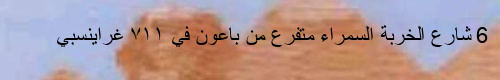

In [54]:
import PIL

PIL.Image.open(df.image.loc[0].values[0])


In [87]:
from sklearn.model_selection import train_test_split 

train , test = train_test_split(df , test_size=0.2 , random_state=3407)

In [ ]:
train_tokens = vectorizer.fit_transform(train.text.values.ravel())
test_tokens = vectorizer.transform(test.text.values.ravel())

In [5]:
import nltk
from nltk.tokenize import WordPunctTokenizer

nltk.download('punkt')

# Example dataset of Arabic text samples
arabic_dataset = ["توكنيز هذا النص إلى أحرف.",
                  "مثال آخر لتفكيك الأحرف العربية.",
                  "١٢٣٤٥"]

# Initialize the WordPunctTokenizer for Arabic
arabic_tokenizer = WordPunctTokenizer()

# Tokenize each Arabic text sample into characters
tokenized_arabic_dataset = [arabic_tokenizer.tokenize(text) for text in arabic_dataset]

# Print the tokenized Arabic dataset
for text_tokens in tokenized_arabic_dataset:
    print(text_tokens)

['توكنيز', 'هذا', 'النص', 'إلى', 'أحرف', '.']
['مثال', 'آخر', 'لتفكيك', 'الأحرف', 'العربية', '.']
['١٢٣٤٥']


[nltk_data] Downloading package punkt to /home/aylore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
from sklearn.feature_extraction.text import CountVectorizer

def tokenize_dl(dataloader , train ):

    df = pd.DataFrame(columns=[["image" , "text" , "embeddings"]])

    for img, text in next(iter(dataloader)):
        images = img
        texts = text
    
    if train:
        vectorizer = CountVectorizer(analyzer='char')
        df.embeddings = vectorizer.fit_transform(df.text.values)

    return df


tokenize_dl(train_dataloader , True)


ValueError: too many values to unpack (expected 2)

In [85]:
torch.cat((batch["image"] , batch["image"] , batch["image"]) , dim=0).shape

torch.Size([48, 1, 32, 280])